## Capítulo 8

In [1]:
from sympy.physics.mechanics import ReferenceFrame,Point,dynamicsymbols
from sympy.physics.mechanics import Point,RigidBody,inertia, KanesMethod
from sympy import latex,pprint,symbols,init_printing
from sympy.algebras.quaternion import Quaternion
from sympy.physics.mechanics import LagrangesMethod, Lagrangian
from scipy.integrate import odeint
from sympy import lambdify
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import sys 
sys.path.append("../tools")
from vis import Visualizer
%matplotlib notebook
init_printing() # Para visualizar símbolos


<IPython.core.display.Javascript object>


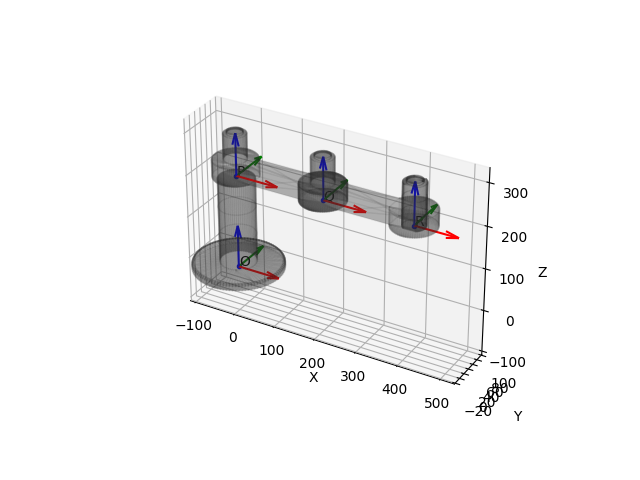

In [2]:
# Definición del modelo para el ejemplo del robot scara

# Parámetros del modelo
l1,l2,l3,rb,rc=symbols('l_1,l_2,l_3,r_b,r_c')
# Parámetros inerciales (note que se usan las variables ib e ic  para la inercia en z).
mb,mc,ib,ic=symbols('m_b,m_c,i_b,i_c') 
# Variables de movimiento
q1,q2=dynamicsymbols('q_1,q_2')

# Defina los marcos y puntos de interés en el robot
a=ReferenceFrame('A')
o=Point('O')
b=a.orientnew('B','Axis',(q1,a.z))
p=o.locatenew('P',l1*a.z)
bstar=p.locatenew('Bstar',rb*b.x)
c=b.orientnew('C','Axis',(q2,b.z))
q=p.locatenew('Q',l2*b.x)
cstar=q.locatenew('Cstar',rc*c.x)
r=q.locatenew('R',l3*c.x)

# Defina los cuerpos rígidos 
#RigidBody(name, masscenter, frame, mass, inertia)
inertia_b=inertia(b,0,0,ib)
inertia_c=inertia(c,0,0,ic)
body_b=RigidBody('B', bstar, b, mb, (inertia_b,bstar))
body_c=RigidBody('C', cstar, c, mc, (inertia_c,cstar))

# Construya un objecto de visualización con el marco de referencia inercial y punto de origen
vis=Visualizer(a,o)
# Agrege marcos y puntos para ser visualizados (marco,punto,geometría)
vis.add(a,o,shape='../Visualizacion/assets/scara_base.stl')
vis.add(b,p,shape='../Visualizacion/assets/scara_brazo.stl')
vis.add(c,q,shape='../Visualizacion/assets/scara_brazo.stl')
vis.add(c,r,shape='../Visualizacion/assets/scara_cilindro.stl')

#vis.add(b,o,shape='assets/Atraccion_Parque_link1.stl')
#vis.add(c,p,shape='assets/Atraccion_Parque_disk.stl')
vis.add(a,o,frame_scale=100)
vis.add(b,p,frame_scale=100)
vis.add(c,q,frame_scale=100)
vis.add(c,r,frame_scale=100)


# Modifique las variables de movimiento y verifique el cambio en la posición y
# orientación de los marcos
vis.plot({l1:220,l2:210,l3:210,q1:0,q2:0})

In [3]:
## 8.1 Ecuaciones iterativas de Newton-Euler

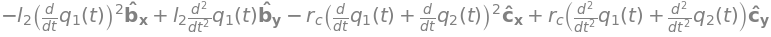

In [4]:
# Primero calcule la cinemática de los cuerpos
# Para esto defina las velocidades de los puntos en cada marco de referencia
p.set_vel(a,0)
q.set_vel(b,0)
cstar.set_vel(c,0)
bstar.set_vel(b,0)
q.v2pt_theory(p,a,b)
bstar.v2pt_theory(p,a,b)
cstar.v2pt_theory(q,b,c)
cstar.v2pt_theory(q,a,c)


# Una vez definidas las velocidades puede calcular las velocidades en el marco A
# Verifique los resultados con los siguientes comandos
#b.ang_vel_in(a)
#c.ang_vel_in(a)
#b.ang_acc_in(a)
#c.ang_acc_in(a)
#bstar.vel(a)
#cstar.vel(a)
#bstar.acc(a)
cstar.acc(a)


In [5]:
#Usando ecuaciones de Newton-Euler (F=ma, M=Icm*alpha+ w x Icm w)
# desde el último objeto en la cadena cinemática puede analizar y resolver
# la cinética.

#Primero para el cuerpo C
# Encuentre la fuerza de reacción F_bc: sum(Fc)=,
F_bc=mc*g*a.z+mc*cstar.acc(a)
# 
M_bc=q.pos_from(c_star).cross(F_bc)+body_c.angular_momentum(cstar,a).dt(a)
M_bc.express(b).simplify()

NameError: name 'g' is not defined

In [ ]:
#Calcule el momento asociado al motor
M2=M_bc.express(b).dot(b.z)
M2

In [ ]:
#Ahora de la sumatoria de fuerzas para el cuerpo B
F_ab=mb*g*a.z+mb*bstar.acc(a)+F_bc
F_ab

In [ ]:
# Y de la sumatoria de momentos para el cuerpo B
M_ab=-q.pos_from(bstar).cross(-F_bc)\
+p.pos_from(bstar).cross(F_ab)\
-body_b.angular_momentum(bstar,a).dt(a)
M_ab.express(b).simplify()

In [ ]:
#Calcule el momento asociado al motor
M_ab.dot(b.z).simplify()

## 8.2 Formulacion de Kane para sistemas multicuerpo


In [ ]:
# Defina nuevamente el modelo del robot Scara, esta vez
# incluya con rapideces generalizadas para definir la cinemática usando
# la formulacion de Kane.

#Coordenadas generalizadas
q1,q2,u1,u2=dynamicsymbols('q1,q2,u1,u2')
#Derivadas qdot y udot
q1d,q2d,u1d,u2d=dynamicsymbols('q1 q2 u1 u2',1)
# Parámetros del modelo
l1,l2,l3,rb,rc,g=symbols('l_1,l_2,l_3,r_b,r_c,g')
# Parámetros inerciales (note que se usan las variables ib e ic  para la inercia en z).
mb,mc,ib,ic=symbols('m_b,m_c,i_b,i_c') 
# Defina variables para los momentos de los motores
M1,M2=symbols('M1,M2')


# Defina los marcos y puntos de interés en el robot
a=ReferenceFrame('A')
o=Point('O')
b=a.orientnew('B','Axis',(q1,a.z))
p=o.locatenew('P',l1*a.z)
bstar=p.locatenew('Bstar',rb*b.x)
c=b.orientnew('C','Axis',(q2,b.z))
q=p.locatenew('Q',l2*b.x)
cstar=q.locatenew('Cstar',rc*c.x)
r=q.locatenew('R',l3*c.x)
# Defina los cuerpos rígidos 
#RigidBody(name, masscenter, frame, mass, inertia)
inertia_b=inertia(b,0,0,ib)
inertia_c=inertia(c,0,0,ic)
body_b=RigidBody('B', bstar, b, mb, (inertia_b,bstar))
body_c=RigidBody('C', cstar, c, mc, (inertia_c,cstar))

p.set_vel(a,0)
q.set_vel(b,0)
cstar.set_vel(c,0)
bstar.set_vel(b,0)
q.v2pt_theory(p,a,b)
bstar.v2pt_theory(p,a,b)
cstar.v2pt_theory(q,b,c)
cstar.v2pt_theory(q,a,c)
b.set_ang_vel(a,u1*a.z)
c.set_ang_vel(b,u2*a.z)

# Puede revisar la cinemática del sistema expresada en rapideces generalizadas
# e.g. 
# b.ang_vel_in(a)
# c.ang_vel_in(a).express(b)
# b.ang_acc_in(a).express(b)
# c.ang_acc_in(a).express(a)
# bstar.vel(a)
# cstar.vel(a)
# bstar.acc(a)
cstar.acc(a)



In [ ]:
# Ecuaciones diferenciales cinemáticas
kd = [q1d-u1, q2d-u2]
km=KanesMethod(a,q_ind=[q1,q2],u_ind=[u1,u2],kd_eqs=kd)
# Tuplas con cuerpos y fuerzas (marcos y momentos)
ftuples=[(body_b.masscenter,body_b.mass*g*a.z),(body_c.masscenter,body_c.mass*g*a.z)]
mtuples=[(b,M1*b.z-M2*b.z),(c,M2*b.z)]
(fr,frstar)=km.kanes_equations([body_b,body_c],ftuples+mtuples)

In [ ]:
# Verifique fr y frstar
#fr
#frstar[1]

In [ ]:
# Genere las ecuaciones de movimiento en espacio de estados:
km.rhs()

# 8.3 Uso de la formulacion de Lagrange en sistemas multicuerpo

In [ ]:
# Defina nuevamente el modelo del robot Scara

#Coordenadas generalizadas
q1,q2=dynamicsymbols('q1,q2')
#Derivadas qdot y udot
q1d,q2d=dynamicsymbols('q1 q2',1)
# Parámetros del modelo
l1,l2,l3,rb,rc,g=symbols('l_1,l_2,l_3,r_b,r_c,g')
# Parámetros inerciales (note que se usan las variables ib e ic  para la inercia en z).
mb,mc,ib,ic=symbols('m_b,m_c,i_b,i_c') 
# Defina variables para los momentos de los motors
M1,M2=symbols('M1,M2')


# Defina los marcos y puntos de interes en el robot
a=ReferenceFrame('A')
o=Point('O')
b=a.orientnew('B','Axis',(q1,a.z))
p=o.locatenew('P',l1*a.z)
bstar=p.locatenew('Bstar',rb*b.x)
c=b.orientnew('C','Axis',(q2,b.z))
q=p.locatenew('Q',l2*b.x)
cstar=q.locatenew('Cstar',rc*c.x)
r=q.locatenew('R',l3*c.x)

p.set_vel(a,0)
q.set_vel(b,0)
cstar.set_vel(c,0)
bstar.set_vel(b,0)
q.v2pt_theory(p,a,b)
bstar.v2pt_theory(p,a,b)
cstar.v2pt_theory(q,b,c)
cstar.v2pt_theory(q,a,c)
b.set_ang_vel(a,q1d*a.z)
c.set_ang_vel(b,q2d*a.z)

# Defina los cuerpos rígidos 
#RigidBody(name, masscenter, frame, mass, inertia)
inertia_b=inertia(b,0,0,ib)
inertia_c=inertia(c,0,0,ic)
body_b=RigidBody('B', bstar, b, mb, (inertia_b,bstar))
body_c=RigidBody('C', cstar, c, mc, (inertia_c,cstar))

In [ ]:
#En este caso todas las masas estan en el mismo plano 
# se supone energía potencial 0.
Lb=Lagrangian(a,body_b)
Lc=Lagrangian(a,body_c)

# Tuplas con cuerpos y fuerzas (marcos y momentos)
ftuples=[(body_b.masscenter,body_b.mass*g*a.z),(body_c.masscenter,body_c.mass*g*a.z)]
mtuples=[(b,M1*b.z-M2*b.z),(c,M2*b.z)]

lm=LagrangesMethod(Lb+Lc,[q1,q2],ftuples+mtuples,frame=a)
lm.form_lagranges_equations()
rhs=lm.rhs()
# Ecuaciones de movimiento en espacio de estados
rhs


In [ ]:
# Finalmente puede utilizar el modelo del sistema para realizar simulaciones
# de dinamica directa utilizando un integrador de ecuaciones diferenciales
# de primer orden.

# Defina las condiciones iniciales del sistema
x0=[0,0,0,0]
# Asigne valores numericos a los parámetros del modelo
# rhs.free_symbols (revise las variables libres del modelo)
parameters={M1:0,M2:0,mb:0.5,mc:0.5,ib:1e-3,ic:1e-3,l2:0.22,rb:0.1,rc:0.1}

#Modifique los valores de M1 y M2 para obtener diferentes resultados en
# la simulación
parameters[M1]=-0.1*q1d-0.1*(q1-0.5)
parameters[M2]=-0.1*q2d-0.1*(q2-0.5)


t=np.linspace(0,20,100)
# Cree una función numérica del modelo del sistema (i.e xdot=f(x))
rhs_fun=lambdify([q1,q2,q1d,q2d],rhs.subs(parameters))
ode_fun=lambda x,t: rhs_fun(x[0],x[1],x[2],x[3]).reshape(4)
x=odeint(ode_fun,x0,t)

plt.figure()
plt.plot(t,x)
plt.legend([q1,q2,q1d,q2d])



In [ ]:
# Y utilizar las herramientas de visualización para observar el movimiento

vis=Visualizer(a,o)
vis.add(a,o,shape='../Visualizacion/assets/scara_base.stl')
vis.add(b,p,shape='../Visualizacion/assets/scara_brazo.stl')
vis.add(c,q,shape='../Visualizacion/assets/scara_brazo.stl')
vis.add(c,r,shape='../Visualizacion/assets/scara_cilindro.stl')
vis.add(a,o,frame_scale=100)
vis.add(b,p,frame_scale=100)
vis.add(c,q,frame_scale=100)
vis.add(c,r,frame_scale=100)

vis.plot({l1:220,l2:parameters[l2]*1000,l3:210,q1:x0[0],q2:x0[0]})

def update(i,data):
    vis.plot({l1:220,l2:parameters[l2]*1000,l3:210,q1:data[i,0],q2:data[i,1]})
    
ani = animation.FuncAnimation(vis.fig, update, x.shape[0], fargs=(x,), interval=20/x.shape[0], blit=False)

# 8.4 Derivacion de un conjunto eficiente de ecuaciones dinamicas

In [ ]:
# Defina nuevamente el modelo del robot Scara, esta vez
# con la rapidez generalizada u2=q1d+q2d para definir la cinematica usando
# la formulacion de Kane.

#Coordenadas generalizadas
q1,q2,u1,u2=dynamicsymbols('q1,q2,u1,u2')
#Derivadas qdot y udot
q1d,q2d,u1d,u2d=dynamicsymbols('q1 q2 u1 u2',1)
# Parámetros del modelo
l1,l2,l3,rb,rc,g=symbols('l_1,l_2,l_3,r_b,r_c,g')
# Parámetros inerciales (note que se usan las variables ib e ic  para la inercia en z).
mb,mc,ib,ic=symbols('m_b,m_c,i_b,i_c') 
# Defina variables para los momentos de los motores
M1,M2=symbols('M1,M2')


# Defina los marcos y puntos de interés en el robot
a=ReferenceFrame('A')
o=Point('O')
b=a.orientnew('B','Axis',(q1,a.z))
p=o.locatenew('P',l1*a.z)
bstar=p.locatenew('Bstar',rb*b.x)
c=b.orientnew('C','Axis',(q2,b.z))
q=p.locatenew('Q',l2*b.x)
cstar=q.locatenew('Cstar',rc*c.x)
r=q.locatenew('R',l3*c.x)
# Defina los cuerpos rígidos 
#RigidBody(name, masscenter, frame, mass, inertia)
inertia_b=inertia(b,0,0,ib)
inertia_c=inertia(c,0,0,ic)
body_b=RigidBody('B', bstar, b, mb, (inertia_b,bstar))
body_c=RigidBody('C', cstar, c, mc, (inertia_c,cstar))

p.set_vel(a,0)
q.set_vel(b,0)
cstar.set_vel(c,0)
bstar.set_vel(b,0)
q.v2pt_theory(p,a,b)
bstar.v2pt_theory(p,a,b)
cstar.v2pt_theory(q,b,c)
cstar.v2pt_theory(q,a,c)
b.set_ang_vel(a,u1*a.z)
c.set_ang_vel(b,q2d*a.z)

# Ecuaciones diferenciales cinemáticas
kd = [q1d-u1, q1d+q2d-u2]
km=KanesMethod(a,q_ind=[q1,q2],u_ind=[u1,u2],kd_eqs=kd)
# Tuplas con cuerpos y fuerzas (marcos y momentos)
ftuples=[(body_b.masscenter,body_b.mass*g*a.z),(body_c.masscenter,body_c.mass*g*a.z)]
mtuples=[(b,M1*b.z-M2*b.z),(c,M2*b.z)]
(fr,frstar)=km.kanes_equations([body_b,body_c],ftuples+mtuples)

frstar
